## **Multi-layer perceptron + Cross Entropy loss**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create time series dataset of length 128 with 3 classes
# training dataset
idx=np.arange(0,128)
train_data_class1=np.sin(2*np.pi*idx/100)+0.5*np.random.randn(5000,128)
train_data_class2=np.sin(2*np.pi*idx/95)+0.5*np.random.randn(5000,128)
train_data_class3=np.sin(2*np.pi*idx/90)+0.5*np.random.randn(5000,128)
x_train=np.concatenate([train_data_class1,train_data_class2,train_data_class3],0)

# test dataset
test_data_class1=np.sin(2*np.pi*idx/100)+0.5*np.random.randn(1000,128)
test_data_class2=np.sin(2*np.pi*idx/95)+0.5*np.random.randn(1000,128)
test_data_class3=np.sin(2*np.pi*idx/90)+0.5*np.random.randn(1000,128)
x_test=np.concatenate([test_data_class1,test_data_class2,test_data_class3],0)

# create labels for training and test data
y_train=np.concatenate([np.zeros(5000),np.ones(5000),np.ones(5000)*2],0)
y_test=np.concatenate([np.zeros(1000),np.ones(1000),np.ones(1000)*2],0)

y_train.astype(int)
y_test.astype(int)
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
y_train=tf.cast(y_train,tf.uint8)
y_test=tf.cast(y_test,tf.uint8)

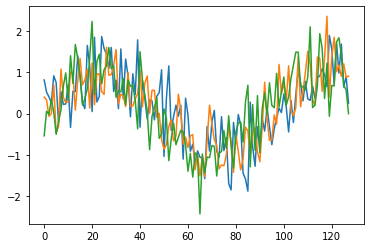

In [3]:
# plot time series data
# class 1
plt.plot(x_train[1])
# class 1
plt.plot(x_train[5000+1])
# class 1
plt.plot(x_train[10000+1])

In [4]:
# dataset parameters.
num_classes = 3 # total classes (0-9 digits).
num_features = 128 # data features (img shape: 28*28).

# Training parameters.
learning_rate = 0.001
training_steps = 3000
batch_size = 256
display_step = 100

# Network parameters.
n_hidden_1 = 128 # 1st layer number of neurons.
n_hidden_2 = 256 # 2nd layer number of neurons.

In [5]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [6]:
# Store layers weight & bias

# A random value generator to initialize weights.
random_normal = tf.initializers.RandomNormal()

weights = {
    'h1': tf.Variable(random_normal([num_features, n_hidden_1])),
    'h2': tf.Variable(random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(random_normal([n_hidden_2, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.zeros([n_hidden_1])),
    'b2': tf.Variable(tf.zeros([n_hidden_2])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

In [7]:

# Create model.
def neural_net(x):
    # Hidden fully connected layer with 128 neurons.
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Apply sigmoid to layer_1 output for non-linearity.
    layer_1 = tf.nn.sigmoid(layer_1)
    
    # Hidden fully connected layer with 256 neurons.
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Apply sigmoid to layer_2 output for non-linearity.
    layer_2 = tf.nn.sigmoid(layer_2)
    
    # Output fully connected layer with a neuron for each class.
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(out_layer)

In [8]:
# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

In [9]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = neural_net(x)
        loss = cross_entropy(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [10]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.

    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 100, loss: 237.979523, accuracy: 0.605469
step: 200, loss: 165.554245, accuracy: 0.917969
step: 300, loss: 48.828873, accuracy: 0.984375
step: 400, loss: 20.395985, accuracy: 0.984375
step: 500, loss: 28.074659, accuracy: 0.964844
step: 600, loss: 44.905815, accuracy: 0.917969
step: 700, loss: 21.223394, accuracy: 0.968750
step: 800, loss: 23.108280, accuracy: 0.972656
step: 900, loss: 34.238213, accuracy: 0.960938
step: 1000, loss: 19.392925, accuracy: 0.964844
step: 1100, loss: 23.429720, accuracy: 0.960938
step: 1200, loss: 35.242180, accuracy: 0.949219
step: 1300, loss: 33.799049, accuracy: 0.953125
step: 1400, loss: 15.574914, accuracy: 0.976562
step: 1500, loss: 31.041296, accuracy: 0.960938
step: 1600, loss: 26.137295, accuracy: 0.964844
step: 1700, loss: 13.711111, accuracy: 0.984375
step: 1800, loss: 25.899824, accuracy: 0.953125
step: 1900, loss: 21.734499, accuracy: 0.980469
step: 2000, loss: 29.477684, accuracy: 0.945312
step: 2100, loss: 20.382816, accuracy: 0.972656

In [11]:
# Test model on validation set.
pred = neural_net(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.954000
